In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
class LinearMixedEffectModel:
    def __init__(self, beta0, beta1, sigma, sigma_b):
        self.beta0 = beta0
        self.beta1 = beta1
        self.sigma = sigma
        self.sigma_b = sigma_b
    
    def sample_b(self, n_groups, rng):
        return rng.normal(0, self.sigma_b, size=n_groups)
    
    def sample_y(self, b, x, rng):
        n_groups, n_measurements = x.shape
        y = np.zeros_like(x, dtype=float)
        for i in range(n_groups):
            y[i, :] = self.beta0 + b[i] + self.beta1 * x[i, :] + rng.normal(0, self.sigma, size=n_measurements)
        return y

In [5]:
def simulate_data(model, n_groups, n_measurements, seed=42):
    rng = np.random.default_rng(seed)
    # Simuler les variables explicatives x, par exemple, de manière uniforme entre 0 et 10
    x_sim = rng.uniform(0, 10, size=(n_groups, n_measurements))
    # Échantillonner les effets aléatoires
    b_sim = model.sample_b(n_groups, rng)
    # Échantillonner les réponses y
    y_sim = model.sample_y(b_sim, x_sim, rng)
    return b_sim, x_sim, y_sim

# Paramètres vrais du modèle
beta0_true = 2.0    # Interception fixe
beta1_true = 3.0    # Pente fixe
sigma_true = 1.0     # Écart-type des résidus
sigma_b_true = 0.5   # Écart-type des effets aléatoires d'interception

# Initialisation du modèle vrai
model_true = LinearMixedEffectModel(beta0=beta0_true, beta1=beta1_true, sigma=sigma_true, sigma_b=sigma_b_true)

# Nombre de groupes et de mesures
n_groups = 50
n_measurements = 20

# Simulation des données
b_sim, x_sim, y_sim = simulate_data(model_true, n_groups, n_measurements, seed=42)

In [6]:
def log_likelihood(theta, y, x, b, n_groups):
    beta0, beta1, sigma, sigma_b = theta
    log_ll = 0.0
    for i in range(n_groups):
        # Log de la densité de b_i
        log_ll += -0.5 * np.log(2 * np.pi * sigma_b**2) - 0.5 * (b[i]**2) / sigma_b**2
        for j in range(y.shape[1]):
            # Log de la densité de y_ij
            mu_ij = beta0 + b[i] + beta1 * x[i, j]
            log_ll += -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((y[i, j] - mu_ij)**2) / sigma**2
    return log_ll

def compute_grad(theta, y, x, b, n_groups):
    beta0, beta1, sigma, sigma_b = theta
    grad_beta0 = 0.0
    grad_beta1 = 0.0
    grad_sigma = 0.0
    grad_sigma_b = 0.0
    
    for i in range(n_groups):
        # Grad beta0
        for j in range(y.shape[1]):
            mu_ij = beta0 + b[i] + beta1 * x[i, j]
            grad_beta0 += (y[i, j] - mu_ij) / sigma**2
        
        # Grad beta1
            grad_beta1 += (y[i, j] - mu_ij) * x[i, j] / sigma**2
        
        # Grad sigma
            grad_sigma += (-1 / sigma) + ((y[i, j] - mu_ij)**2) / sigma**3
        
        # Grad sigma_b
            grad_sigma_b += (-1 / sigma_b) + (b[i]**2) / sigma_b**3
    
    # Faire une moyenne
    n_total = n_groups * y.shape[1]
    grad_theta = np.array([
        grad_beta0 / n_total,
        grad_beta1 / n_total,
        grad_sigma / n_total,
        grad_sigma_b / n_groups
    ])
    
    return grad_theta

In [7]:
def sample_b_i(y_i, x_i, beta0, beta1, sigma, sigma_b, rng):
    n_j = len(y_i)
    # Calculer la moyenne et la variance de la distribution conditionnelle de b_i
    sigma_b_sq = sigma_b**2
    sigma_sq = sigma**2
    sum_y_mu = np.sum(y_i - beta0 - beta1 * x_i)
    mu_cond = (sum_y_mu) / (n_j * sigma_sq / sigma_b_sq + 1)
    sigma_cond_sq = (sigma_sq * sigma_b_sq) / (n_j * sigma_sq + sigma_b_sq)
    
    # Échantillonner b_i à partir de N(mu_cond, sigma_cond_sq)
    b_i_new = rng.normal(mu_cond, np.sqrt(sigma_cond_sq))
    return b_i_new

def sample_b(y, x, theta, n_groups, rng):
    beta0, beta1, sigma, sigma_b = theta
    b_new = np.zeros(n_groups, dtype=float)
    for i in range(n_groups):
        b_new[i] = sample_b_i(y[i, :], x[i, :], beta0, beta1, sigma, sigma_b, rng)
    return b_new


In [41]:
def fisher_sgd_mixed_effect(y, x, initial_theta, initial_b, K_pre_heating = 1000, K_heating = 2000, eta=0.01, beta=0.01, lambda_reg=1e-6, K=1000, n_groups=50, batch_size=10, alpha=2/3, seed=42):
    rng = np.random.default_rng(seed)
    theta = initial_theta.copy()
    b = initial_b.copy()
    
    # Initialisation de la matrice Fisher
    F = lambda_reg * np.eye(len(theta))
    
    thetas_est = [theta.copy()]
    
    for epoch in tqdm(range(K), desc="Fisher-SGD"):
        # Échantillonnage des effets aléatoires
        b = sample_b(y, x, theta, n_groups, rng)

        if epoch < K_pre_heating:
            gamma_k = np.exp((1-epoch/K_pre_heating)*np.log(eta))
        elif K_pre_heating <= epoch <= K_heating:
            gamma_k = 1
        else: 
            gamma_k = 1/(epoch-K_heating)**(alpha)
        
        group_indices = np.arange(n_groups)
        rng.shuffle(group_indices)
        
        # Mini-batch
        for i in range(0, n_groups, batch_size):
            batch_indices = group_indices[i:i+batch_size]
            y_batch = y[batch_indices, :]
            x_batch = x[batch_indices, :]
            b_batch = b[batch_indices]
            
            # Calcul du gradient pour le batch
            grad_theta = compute_grad(theta, y_batch, x_batch, b_batch, len(batch_indices))
            
            # Mise à jour de la matrice Fisher
            grad_outer = np.outer(grad_theta, grad_theta)
            F = (1 - beta) * F + beta * grad_outer
            
            # Préconditionnement : inv(F + lambda_reg * I)
            F_reg = F + lambda_reg * np.eye(len(theta))
            
            try:
                F_inv = np.linalg.inv(F_reg)
            except np.linalg.LinAlgError:
                print(f"Matrice Fisher non inversible à l'epoch {epoch}")
                F_inv = np.linalg.pinv(F_reg)
            
            # Mise à jour des paramètres
            theta_update = gamma_k * (F_inv @ grad_theta)
            theta = theta + theta_update
        
        # Stocker les estimations pour analyse
        thetas_est.append(theta.copy())
    
    # Estimation finale de la matrice d'information de Fisher
    fisher_info = F / K
    
    return thetas_est, fisher_info


In [42]:
# Initialisation des paramètres
initial_theta = np.array([1.0, 1.0, 2.0, 1.0])  # beta0, beta1, sigma, sigma_b
initial_b = np.zeros(n_groups)  # Effets aléatoires initiaux

# Paramètres de l'algorithme
eta = 0.01         # Taux d'apprentissage
beta = 0.01        # Taux de mise à jour de Fisher
lambda_reg = 1e-6  # Régularisation pour l'inversion
K = 3000           # Nombre d'epochs
batch_size = 10    # Taille des mini-batchs
seed = 42          # Graine pour reproductibilité

thetas_est, fisher_info = fisher_sgd_mixed_effect(
    y=y_sim,
    x=x_sim,
    initial_theta=initial_theta,
    initial_b=initial_b,
    K_pre_heating = 1000, 
    K_heating = 2000,
    eta=eta,
    beta=beta,
    lambda_reg=lambda_reg,
    K=K,
    n_groups=n_groups,
    batch_size=batch_size,
    alpha = 2/3,
    seed=seed
)

thetas_est = np.array(thetas_est)
theta_true = np.array([beta0_true, beta1_true, sigma_true, sigma_b_true])

Fisher-SGD:   0%|          | 0/3000 [00:00<?, ?it/s]

Fisher-SGD: 100%|██████████| 3000/3000 [00:14<00:00, 206.35it/s]


In [43]:
print("Paramètres vrais:")
print(f"beta0={beta0_true}, beta1={beta1_true}, sigma={sigma_true}, sigma_b={sigma_b_true}")

print("\nParamètres initiales:")
print(f"pi={initial_theta[0]}, mu1={initial_theta[1]}, mu2={initial_theta[2]}, sigma1={initial_theta[3]}")

print("\nParamètres estimés (à la dernière epoch):")
print(f"beta0={thetas_est[-1,0]:.4f}, beta1={thetas_est[-1,1]:.4f}, "
      f"sigma={thetas_est[-1,2]:.4f}, sigma_b={thetas_est[-1,3]:.4f}")

Paramètres vrais:
beta0=2.0, beta1=3.0, sigma=1.0, sigma_b=0.5

Paramètres initiales:
pi=1.0, mu1=1.0, mu2=2.0, sigma1=1.0

Paramètres estimés (à la dernière epoch):
beta0=-27.3534, beta1=2.5254, sigma=1.0947, sigma_b=1.9773


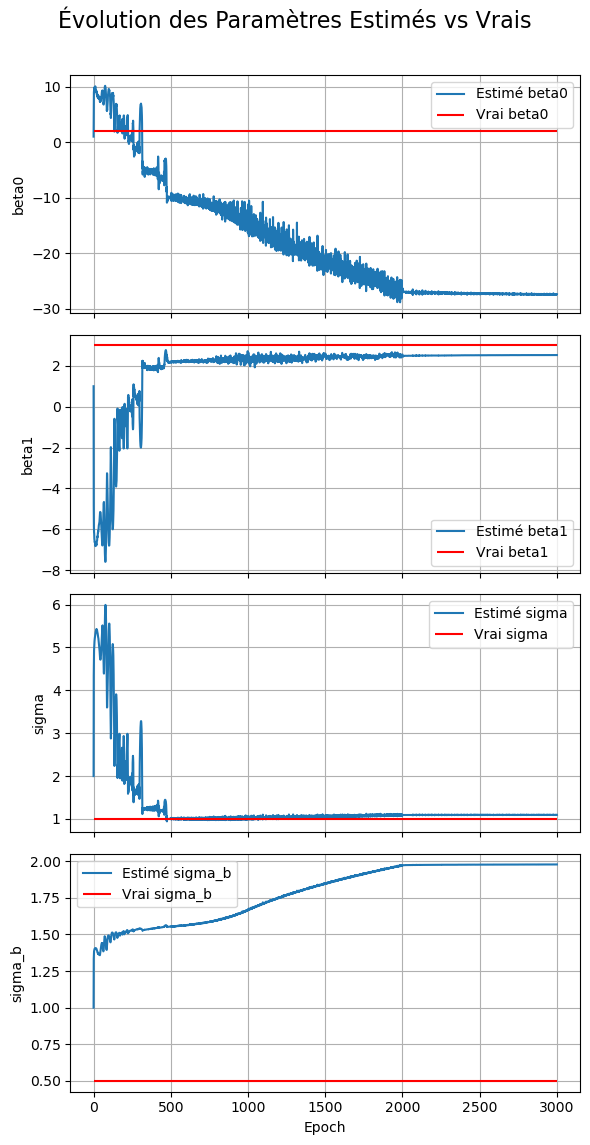

In [44]:
# Labels des paramètres
labels = ['beta0', 'beta1', 'sigma', 'sigma_b']
colors_true = ['red', 'red', 'red', 'red']
colors_est = ['blue', 'blue', 'blue', 'blue']

# Créer des sous-graphiques pour chaque paramètre
fig, axes = plt.subplots(4, 1, figsize=(6, 12), sharex=True)

for idx, ax in enumerate(axes):
    ax.plot(thetas_est[:, idx], label=f'Estimé {labels[idx]}')
    ax.hlines(theta_true[idx], 0, K, colors='red', label=f'Vrai {labels[idx]}')
    ax.set_ylabel(labels[idx])
    ax.legend()
    ax.grid(True)

axes[-1].set_xlabel('Epoch')
plt.suptitle('Évolution des Paramètres Estimés vs Vrais', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()
